# POS Tagging using modified Viterbi

__Author__: Adrish Maity

## Data Preparation

In [1]:
#Importing libraries
import nltk

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

from IPython.display import Markdown, display

# for display full data frame
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# reading the test data
with open("Test_sentences.txt", "r") as file:
    test_data = file.read()

In [4]:
# checking the length of the nltk data
len(nltk_data)

3914

In [6]:
# checking the initial 5 tagged sentences from the data set
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [7]:
# Splitting the nltk data into train and validation data set
random.seed(83)
train_set, validation_set = train_test_split(nltk_data,train_size =0.95, test_size=0.05, random_state=83)

# Get the number of data points
print("Number of train data --> ",len(train_set))
print("Number of validation data --> ",len(validation_set))

print(20*"=="+"\nSample Train Data\n"+20*"==")
# Display the initial 5 tagged sentences from the train set
print(train_set[:5])

Number of train data -->  3718
Number of validation data -->  196
Sample Train Data
[[('It', 'PRON'), ('*EXP*-3', 'X'), ("'s", 'VERB'), ('probably', 'ADV'), ('true', 'ADJ'), ('that', 'ADP'), ('many', 'ADJ'), ('salarymen', 'NOUN'), ('put', 'VERB'), ('in', 'PRT'), ('unproductive', 'ADJ'), ('overtime', 'NOUN'), ('just', 'ADV'), ('for', 'ADP'), ('the', 'DET'), ('sake', 'NOUN'), ('of', 'ADP'), ('solidarity', 'NOUN'), (',', '.'), ('that', 'ADP'), ('the', 'DET'), ('system', 'NOUN'), ('is', 'VERB'), ('so', 'ADV'), ('hierarchical', 'ADJ'), ('that', 'ADP'), ('only', 'ADV'), ('the', 'DET'), ('assistant', 'ADJ'), ('manager', 'NOUN'), ('can', 'VERB'), ('talk', 'VERB'), ('to', 'PRT'), ('the', 'DET'), ('manager', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('manager', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('general', 'ADJ'), ('manager', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('that', 'ADP'), ('Sony', 'NOUN'), ('was', 'VERB'), ('chary', 'ADJ'), ('of', 'ADP'), ('*-4', 'X'), ('letting', 'VERB'), ('a', 'D

In [8]:
# Getting list of tagged words from train set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95591

In [9]:
# get the word tokens from the train set
tokens = [pair[0] for pair in train_tagged_words]

# check the first 10 word tokens
tokens[:10]

['It',
 '*EXP*-3',
 "'s",
 'probably',
 'true',
 'that',
 'many',
 'salarymen',
 'put',
 'in']

In [10]:
# get the vocabulary or unique words from the train data
V = set(tokens)
print(len(V))

12043


In [11]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [12]:
print(T)

{'PRON', 'NOUN', 'VERB', 'ADP', 'ADV', 'NUM', 'ADJ', 'CONJ', '.', 'X', 'PRT', 'DET'}


### Emission Probabilities

In [13]:
# define function to compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [14]:
# define function to compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1, train_tagged_words)[0]/t2_given_t1(t2, t1, train_tagged_words)[1]

In [16]:
tags_matrix

array([[7.63067510e-03, 2.07554370e-01, 4.86455560e-01, 2.28920262e-02,
        3.35749723e-02, 7.63067510e-03, 7.36360177e-02, 4.57840506e-03,
        4.08241116e-02, 9.38573033e-02, 1.29721481e-02, 8.39374308e-03],
       [4.78783669e-03, 2.63733059e-01, 1.47143751e-01, 1.77625090e-01,
        1.70315411e-02, 9.50257666e-03, 1.20609626e-02, 4.24692072e-02,
        2.38770515e-01, 2.89828591e-02, 4.45524640e-02, 1.33401556e-02],
       [3.57142873e-02, 1.10241711e-01, 1.68422684e-01, 9.18035358e-02,
        8.18872005e-02, 2.29315162e-02, 6.50759190e-02, 5.11310808e-03,
        3.53269279e-02, 2.18469173e-01, 3.06786485e-02, 1.34335294e-01],
       [6.90095872e-02, 3.22683692e-01, 7.88072404e-03, 1.70394033e-02,
        1.35250269e-02, 6.19808324e-02, 1.05963789e-01, 8.51970166e-04,
        3.96166146e-02, 3.47177833e-02, 1.38445152e-03, 3.25346112e-01],
       [1.48809524e-02, 3.24074067e-02, 3.45899463e-01, 1.16732806e-01,
        7.93650821e-02, 3.17460336e-02, 1.30621687e-01, 6.28

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [18]:
tags_df

,PRON,NOUN,VERB,ADP,ADV,NUM,ADJ,CONJ,.,X,PRT,DET
PRON,0.007631,0.207554,0.486456,0.022892,0.033575,0.007631,0.073636,0.004578,0.040824,0.093857,0.012972,0.008394
NOUN,0.004788,0.263733,0.147144,0.177625,0.017032,0.009503,0.012061,0.042469,0.238771,0.028983,0.044552,0.013340
VERB,0.035714,0.110242,0.168423,0.091804,0.081887,0.022932,0.065076,0.005113,0.035327,0.218469,0.030679,0.134335
ADP,0.069010,0.322684,0.007881,0.017039,0.013525,0.061981,0.105964,0.000852,0.039617,0.034718,0.001384,0.325346
ADV,0.014881,0.032407,0.345899,0.116733,0.079365,0.031746,0.130622,0.006283,0.136243,0.023810,0.014550,0.067460
NUM,0.001500,0.356029,0.017696,0.035993,0.002400,0.183263,0.033293,0.013797,0.117277,0.208758,0.026695,0.003299
ADJ,0.000659,0.700049,0.012354,0.077417,0.004777,0.020590,0.066216,0.017295,0.063416,0.021413,0.010871,0.004942
CONJ,0.058989,0.354869,0.155431,0.052903,0.055243,0.041667,0.110019,0.000468,0.036985,0.008427,0.004213,0.120787
.,0.066600,0.218236,0.089734,0.092626,0.053226,0.079884,0.044099,0.058287,0.092355,0.027652,0.002440,0.174770
X,0.056739,0.060871,0.204228,0.143675,0.026224,0.002861,0.016529,0.009695,0.163541,0.074857,0.185950,0.054832


In [19]:
# get the tag probabilities to be at the inital position of a sentence
tags_df.loc[['.'], :].T.style.highlight_max()

,.
PRON,0.0666004
NOUN,0.218236
VERB,0.0897343
ADP,0.0926261
ADV,0.0532261
NUM,0.0798843
ADJ,0.044099
CONJ,0.0582866
.,0.092355
X,0.0276523


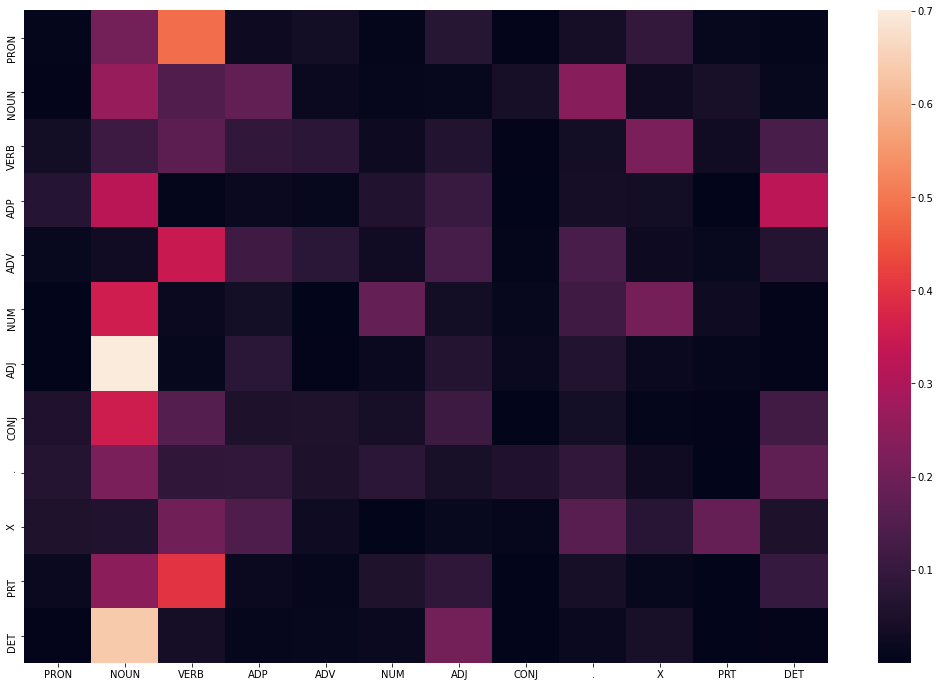

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


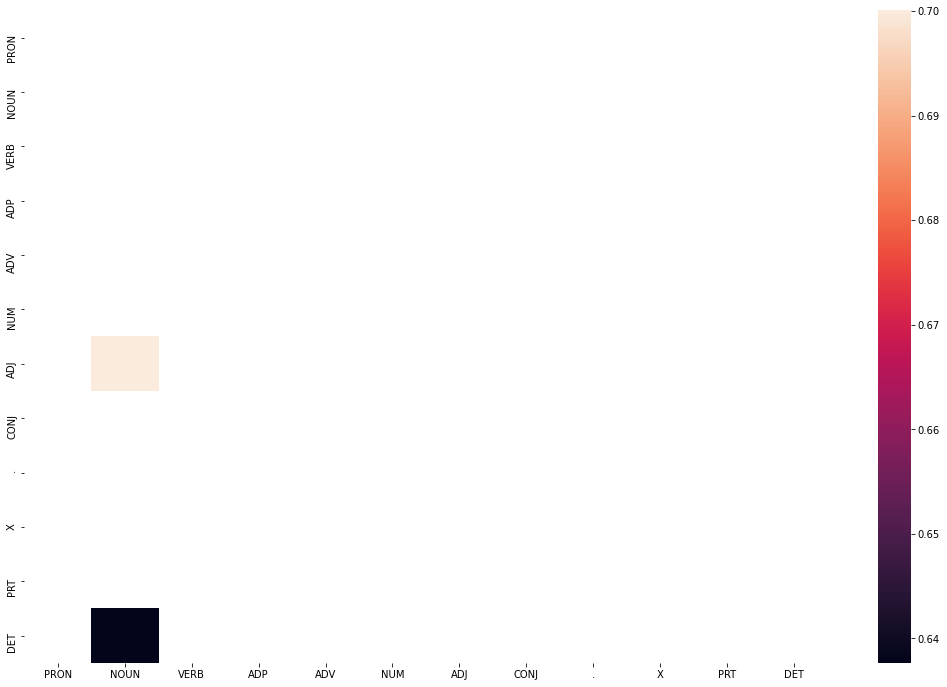

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

This shows that there is a high probability of getting 
- `DET` followed by `NOUN`
- `ADJ` followed by `NOUN`

### Build the vanilla Viterbi based POS tagger

In [22]:
# Verify the length of the trainning words
len(train_tagged_words)

95591

In [23]:
# Viterbi Heuristic
# For each word find the transmission and emission probabilities and calculates the state probability. 
# Assign tag to word based on the highest state probability

def Viterbi(words, train_bag):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        status = round(100*(key+1)/len(words), 2)
        if status < 10:
            status = "  {0:.2f}%\t".format(status)
        elif status < 100:
            status = " {0:.2f}%\t".format(status)
        else:
            status = "{0:.2f}%".format(status)
            
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag, train_bag)[0]/word_given_tag(words[key], tag, train_bag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
        print("\rRunning--> "+status+"\t", end="\r", flush=True)
    return list(zip(words, state))

#### Evaluate on validation data

In [24]:
validation_set[:2]

[[('A', 'DET'),
  ('former', 'ADJ'),
  ('member', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('prosecution', 'NOUN'),
  ('team', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('Iran\\/Contra', 'NOUN'),
  ('affair', 'NOUN'),
  ('joined', 'VERB'),
  ('the', 'DET'),
  ('Chicago', 'NOUN'),
  ('firm', 'NOUN'),
  ('of', 'ADP'),
  ('Mayer', 'NOUN'),
  (',', '.'),
  ('Brown', 'NOUN'),
  ('&', 'CONJ'),
  ('Platt', 'NOUN'),
  ('.', '.')],
 [('NL', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-1', 'X'),
  ('closed', 'VERB'),
  ('*-2', 'X'),
  ('unchanged', 'ADJ'),
  ('at', 'ADP'),
  ('22', 'NUM'),
  ('3\\/4', 'NUM'),
  (',', '.'),
  ('has', 'VERB'),
  ('a', 'DET'),
  ('stake', 'NOUN'),
  ('of', 'ADP'),
  ('just', 'ADV'),
  ('under', 'ADP'),
  ('10', 'NUM'),
  ('%', 'NOUN'),
  ('.', '.')]]

In [26]:
# list of tagged validation words
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged validation words
validaion_untagged_words = [tup[0] for sent in validation_set for tup in sent]

In [27]:
# tagging the validation sentences
start = time.time()
validation_tagged_seq = Viterbi(words=validaion_untagged_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [28]:
print("Time taken in seconds: ", round(difference))

Time taken in seconds:  1072


In [29]:
# accuracy on validation dataset
check = [i for i, j in zip(validation_tagged_seq, validation_run_base) if i == j] 
accuracy = len(check)/len(validation_tagged_seq)
print("Validation Accuracy -->", round(100*accuracy, 3), "%")

Validation Accuracy --> 90.147 %


In [30]:
incorrect_tagged_cases_validation = [[validation_run_base[i-1],j[0],j[1]] for i, j in enumerate(zip(validation_tagged_seq, validation_run_base)) if j[0]!=j[1]]

In [31]:
# get the incorrectly tagged words from the validation set

pd.DataFrame(incorrect_tagged_cases_validation, 
             columns=["Prev_word_tag", "Pred_cur_word_tag", "Actual_cur_word_tag"])

,Prev_word_tag,Pred_cur_word_tag,Actual_cur_word_tag
0,"(the, DET)","(Iran\/Contra, PRON)","(Iran\/Contra, NOUN)"
1,"(Iran\/Contra, NOUN)","(affair, PRON)","(affair, NOUN)"
2,"(of, ADP)","(Mayer, PRON)","(Mayer, NOUN)"
3,"(and, CONJ)","(dancing, PRON)","(dancing, NOUN)"
4,"(net, ADJ)","(importer, PRON)","(importer, NOUN)"
5,"(for, ADP)","(alleged, ADJ)","(alleged, VERB)"
6,"(John, NOUN)","(Morrell, PRON)","(Morrell, NOUN)"
7,"(a, DET)","(meatpacking, PRON)","(meatpacking, NOUN)"
8,"(United, NOUN)","(Brands, PRON)","(Brands, NOUN)"
9,"(gaining, VERB)","(1,200, PRON)","(1,200, NUM)"


> #### Test the `vanila Viterbi algorithm` with `unknow` test data

In [32]:
# Tokenize the test data

test_words = word_tokenize(test_data)

test_words[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

In [33]:
# tagging the test sentences
start = time.time()
test_tagged_seq = Viterbi(words=test_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [34]:
# Checking the tagged test words
test_df = pd.DataFrame(test_tagged_seq, columns=['Word', 'Tag'])

test_df

,Word,Tag
0,Android,PRON
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN
5,system,NOUN
6,developed,VERB
7,by,ADP
8,Google,PRON
9,.,.


> Cases which are `incorrectly tagged` by POS tagger

| Word        | incorrect_tag
| ----        | -------------
| Android     | 'PRT'       
| Twitter     | 'PRT'       
| Satellite   | 'PRT'       

### Solve the problem of unknown words

> Analyse the unknown tagged words from __validation data__

In [35]:
incorrect_tagged_cases_validation

[[('the', 'DET'), ('Iran\\/Contra', 'PRON'), ('Iran\\/Contra', 'NOUN')],
 [('Iran\\/Contra', 'NOUN'), ('affair', 'PRON'), ('affair', 'NOUN')],
 [('of', 'ADP'), ('Mayer', 'PRON'), ('Mayer', 'NOUN')],
 [('and', 'CONJ'), ('dancing', 'PRON'), ('dancing', 'NOUN')],
 [('net', 'ADJ'), ('importer', 'PRON'), ('importer', 'NOUN')],
 [('for', 'ADP'), ('alleged', 'ADJ'), ('alleged', 'VERB')],
 [('John', 'NOUN'), ('Morrell', 'PRON'), ('Morrell', 'NOUN')],
 [('a', 'DET'), ('meatpacking', 'PRON'), ('meatpacking', 'NOUN')],
 [('United', 'NOUN'), ('Brands', 'PRON'), ('Brands', 'NOUN')],
 [('gaining', 'VERB'), ('1,200', 'PRON'), ('1,200', 'NUM')],
 [('Jack', 'NOUN'), ('Mogavero', 'PRON'), ('Mogavero', 'NOUN')],
 [(',', '.'), ('Piscataway', 'PRON'), ('Piscataway', 'NOUN')],
 [('was', 'VERB'), ('47.1', 'PRON'), ('47.1', 'NUM')],
 [('the', 'DET'), ('YMCA', 'PRON'), ('YMCA', 'NOUN')],
 [('the', 'DET'), ('YWCA', 'PRON'), ('YWCA', 'NOUN')],
 [('or', 'CONJ'), ('Catholic', 'PRON'), ('Catholic', 'NOUN')],
 [('Ch

In [36]:
# Find the tags and the number of times the tags were incorrectly tagged by the algorithm

from collections import Counter

correct_pos_tags = [val[2][1] for val in incorrect_tagged_cases_validation]

print(Counter(correct_pos_tags))

Counter({'NOUN': 245, 'ADJ': 82, 'VERB': 80, 'NUM': 30, 'ADV': 27, 'DET': 12, 'ADP': 10, 'X': 8, 'PRT': 7})


> We can see that there `NOUN` is the most common word where the word is tagged incorrectly.

### Viterbi Modification -1: 

All unknown words 
- replaced by __Noun__ (__Noun__ being the most common tag)


In [37]:
def Viterbi_modf1(words, train_bag):
    tagged_seq = Viterbi(words=words, train_bag = train_bag)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            Viterbi_tags[key] = 'NOUN'

    return list(zip(words, Viterbi_tags))

In [38]:
# tagging the test sentences
start = time.time()
validation_tagged_seq_modf1 = Viterbi_modf1(words=validaion_untagged_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [39]:
print("Time taken in seconds: ", round(difference))

Time taken in seconds:  1043


In [40]:
# accuracy
check = [i for i, j in zip(validation_tagged_seq_modf1, validation_run_base) if i == j] 
accuracy_1 = len(check)/len(validation_tagged_seq_modf1)
print("Validation Accuracy -->", round(100*accuracy_1, 3), "%")

Validation Accuracy --> 94.238 %


In [41]:
incorrect_tagged_cases_validation_modf1 = [[validation_run_base[i-1],j[0],j[1]] for i, j in enumerate(zip(validation_tagged_seq_modf1, validation_run_base)) if j[0]!=j[1]]

In [42]:
# get the incorrectly tagged words from the validation set

pd.DataFrame(incorrect_tagged_cases_validation_modf1, 
             columns=["Prev_word_tag", "Pred_cur_word_tag", "Actual_cur_word_tag"])

,Prev_word_tag,Pred_cur_word_tag,Actual_cur_word_tag
0,"(for, ADP)","(alleged, ADJ)","(alleged, VERB)"
1,"(gaining, VERB)","(1,200, NOUN)","(1,200, NUM)"
2,"(was, VERB)","(47.1, NOUN)","(47.1, NUM)"
3,"(organizations, NOUN)","(that, ADP)","(that, DET)"
4,"(*T*-17, X)","(participated, NOUN)","(participated, VERB)"
5,"(?, .)","(Long-term, NOUN)","(Long-term, ADJ)"
6,"(The, DET)","('82, NOUN)","('82, NUM)"
7,"($, .)","(245, NOUN)","(245, NUM)"
8,"(Argentina, NOUN)","(aspires, NOUN)","(aspires, VERB)"
9,"(its, PRON)","(external, NOUN)","(external, ADJ)"


> #### Test the `Modified Viterbi algorithm` with `unknow` test data

In [43]:
# tagging the test sentences
start = time.time()
test_tagged_seq_1 = Viterbi_modf1(words=test_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [44]:
# Checking the tagged test words
test_df_modf1 = pd.DataFrame(test_tagged_seq_1, columns=['Word', 'Tag'])

test_df_modf1

,Word,Tag
0,Android,NOUN
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN
5,system,NOUN
6,developed,VERB
7,by,ADP
8,Google,NOUN
9,.,.


> Cases which were `incorrectly tagged` by original POS tagger and got `corrected` after modifications

| Word        | Prv_incorrect_tag | corrected_tag
| ----        | ----------------- | -------------
| Android     | 'PRT'             | 'NOUN'
| Twitter     | 'PRT'             | 'NOUN'
| Satellite   | 'PRT'             | 'NOUN'

> There are still some `incorrect tags` present

| Word        | incorrect_tag 
| ----        | -------------
| 2015        | 'NOUN'        
| 2011        | 'NOUN'        
| 2013        | 'NOUN'        

### Viterbi Modification -2: 

All unknown words 
- with first letter capital/ all letters capitals are tagged as Noun, 
- numbers are tagged as NUM, 
- words ending with '-ous' as ADJ, 
- words ending with '-ing' as VERB
- rest as Noun


In [45]:
def checkIfNumber(word):
    try:
        return isinstance(float(word.replace(',','.')), float)
    except:
        return False

In [46]:

def Viterbi_modf2(words, train_bag):
    tagged_seq = Viterbi(words=words, train_bag=train_bag)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            
            
            ## word ending with '-ous'
            if word[-3:] == 'ous':
                Viterbi_tags[key] = 'ADJ'
                
            ## word ending with '-ing'
            elif word[-3:] == 'ing':
                Viterbi_tags[key] = 'VERB'             
            
            ## if word is number
            elif checkIfNumber(word) == True:
                Viterbi_tags[key] = 'NUM'
                
            ## all letters capitalised
            elif word.upper() == word:
                Viterbi_tags[key] = 'NOUN'
                
            ## first letter is capitalised:
            elif word[0].upper() == word[0]:
                Viterbi_tags[key] = 'NOUN' 
                
            else: 
                Viterbi_tags[key] = 'NOUN'
    
    return list(zip(words, Viterbi_tags))

In [47]:
# tagging the test sentences
start = time.time()
validation_tagged_seq_modf2 = Viterbi_modf2(words=validaion_untagged_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [48]:
print("Time taken in seconds: ", round(difference))

Time taken in seconds:  1044


In [49]:
# accuracy
check = [i for i, j in zip(validation_tagged_seq_modf2, validation_run_base) if i == j] 
accuracy_2 = len(check)/len(validation_tagged_seq_modf2)
print("Validation Accuracy -->", round(100*accuracy_2, 3), "%")

Validation Accuracy --> 94.946 %


In [50]:
incorrect_tagged_cases_validation_modf2 = [[validation_run_base[i-1],j[0],j[1]] for i, j in enumerate(zip(validation_tagged_seq_modf2, validation_run_base)) if j[0]!=j[1]]

In [51]:
# get the incorrectly tagged words from the validation set

pd.DataFrame(incorrect_tagged_cases_validation_modf2, 
             columns=["Prev_word_tag", "Pred_cur_word_tag", "Actual_cur_word_tag"])

,Prev_word_tag,Pred_cur_word_tag,Actual_cur_word_tag
0,"(and, CONJ)","(dancing, VERB)","(dancing, NOUN)"
1,"(for, ADP)","(alleged, ADJ)","(alleged, VERB)"
2,"(a, DET)","(meatpacking, VERB)","(meatpacking, NOUN)"
3,"(organizations, NOUN)","(that, ADP)","(that, DET)"
4,"(*T*-17, X)","(participated, NOUN)","(participated, VERB)"
5,"(?, .)","(Long-term, NOUN)","(Long-term, ADJ)"
6,"(The, DET)","('82, NOUN)","('82, NUM)"
7,"(Argentina, NOUN)","(aspires, NOUN)","(aspires, VERB)"
8,"(its, PRON)","(external, NOUN)","(external, ADJ)"
9,"(is, VERB)","(payable, NOUN)","(payable, ADJ)"


> #### Test the `Modified Viterbi algorithm` with `unknow` test data

In [52]:
# tagging the test sentences
start = time.time()
test_tagged_seq_2 = Viterbi_modf2(words=test_words, train_bag = train_tagged_words)
end = time.time()
difference = end-start

In [53]:
# Checking the tagged test words
test_df_modf2 = pd.DataFrame(test_tagged_seq_2, columns=['Word', 'Tag'])

test_df_modf2

,Word,Tag
0,Android,NOUN
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN
5,system,NOUN
6,developed,VERB
7,by,ADP
8,Google,NOUN
9,.,.


> Cases which were `incorrectly tagged` by original POS tagger and got `corrected` after modifications

| Word        | Prv_incorrect_tag | corrected_tag
| ----        | ----------------- | -------------
| Android     | 'PRT'            | 'NOUN'
| Twitter     | 'PRT'            | 'NOUN'
| Satellite   | 'PRT'            | 'NOUN'
| 2015        | 'NOUN'            | 'NUM'
| 2011        | 'NOUN'            | 'NUM'
| 2013        | 'NOUN'            | 'NUM'


### Viterbi Modification -3: 
- state probability is dependent only on transition probability in case of unknown words

In [54]:

def Viterbi_modf3(words, train_bag, only_transmission=True):
    '''
    only_transmission : boolean : 
    Default is True to transmit only transition probability if unknown word occurs. 
    '''
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        status = round(100*(key+1)/len(words), 2)
        if status < 10:
            status = "  {0:.2f}%\t".format(status)
        elif status < 100:
            status = " {0:.2f}%\t".format(status)
        else:
            status = "{0:.2f}%".format(status)

        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag, train_bag)[0]/word_given_tag(words[key], tag, train_bag)[1]
            
            if word in V:
                state_probability = transition_p * emission_p
            else:
                if only_transmission:
                    state_probability = transition_p
                else:
                    state_probability = transition_p * emission_p
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
        print("\rRunning--> "+status+"\t", end="\r", flush=True)
        
    return list(zip(words, state))

>  __Using only transition probability__

In [55]:
# tagging the validation sentences

start = time.time()
validation_tagged_seq_modf3_trans = Viterbi_modf3(words=validaion_untagged_words, 
                                                  train_bag = train_tagged_words, 
                                                  only_transmission=True
                                                 )
end = time.time()
difference = end-start

In [56]:
# accuracy
check = [i for i, j in zip(validation_tagged_seq_modf3_trans, validation_run_base) if i == j] 
accuracy_3 = len(check)/len(validation_tagged_seq_modf3_trans)
print("Validation Accuracy -->", round(100*accuracy_3, 3), "%")

Validation Accuracy --> 93.923 %


In [57]:
print("Time taken in seconds: ", round(difference))

Time taken in seconds:  1057


In [58]:
incorrect_tagged_cases_validation_modf3_trans = [[validation_run_base[i-1],j[0],j[1]] for i, j in enumerate(zip(validation_tagged_seq_modf3_trans, validation_run_base)) if j[0]!=j[1]]

In [59]:
# get the incorrectly tagged words from the validation set

pd.DataFrame(incorrect_tagged_cases_validation_modf3_trans, 
             columns=["Prev_word_tag", "Pred_cur_word_tag", "Actual_cur_word_tag"])

,Prev_word_tag,Pred_cur_word_tag,Actual_cur_word_tag
0,"(of, ADP)","(Mayer, DET)","(Mayer, NOUN)"
1,"(for, ADP)","(alleged, ADJ)","(alleged, VERB)"
2,"(gaining, VERB)","(1,200, X)","(1,200, NUM)"
3,"(was, VERB)","(47.1, X)","(47.1, NUM)"
4,"(organizations, NOUN)","(that, ADP)","(that, DET)"
5,"(?, .)","(Long-term, NOUN)","(Long-term, ADJ)"
6,"(The, DET)","('82, NOUN)","('82, NUM)"
7,"($, .)","(245, NOUN)","(245, NUM)"
8,"(Argentina, NOUN)","(aspires, NOUN)","(aspires, VERB)"
9,"(its, PRON)","(external, VERB)","(external, ADJ)"


> #### Test the `Modified Viterbi algorithm` with `unknow` test data

In [60]:
# tagging the test sentences
start = time.time()
test_tagged_seq_3_trans = Viterbi_modf3(words=test_words,
                                        train_bag = train_tagged_words,
                                        only_transmission=True
                                       )
end = time.time()
difference = end-start

In [61]:
# Checking the tagged test words
test_df_modf3_trans = pd.DataFrame(test_tagged_seq_3_trans, columns=['Word', 'Tag'])

test_df_modf3_trans

,Word,Tag
0,Android,NOUN
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN
5,system,NOUN
6,developed,VERB
7,by,ADP
8,Google,DET
9,.,.


> Cases which were `incorrectly tagged` by original POS tagger and got `corrected` after modifications

| Word        | Prv_incorrect_tag | corrected_tag
| ----        | ----------------- | -------------
| Android     | 'PRT'            | 'NOUN'
| Twitter     | 'PRT'            | 'NOUN'
| Satellite   | 'PRT'            | 'NOUN'

### Comparing tagging accuracies of diferent versions of Viterbi Algorithm

In [62]:
all_algorithms = pd.DataFrame({
                    'Algorithm': ['Vanilla Viterbi', 'Viterbi Modification 1', 'Viterbi Modification 2', 'Viterbi Modification 3'],
                    'Accuracy': [round(100*accuracy,3), round(100*accuracy_1,3), round(100*accuracy_2,3), round(100*accuracy_3,3)],
                    'Description': [
                                    'Based on transition and emmision probability',
                                    'On top of default algorithm handle unknown words by tagging to NOUN',
                                    'On top of default algorithm handle unknown words with pattern of words',
                                    'On top of default algorithm handle unknown words by transmitting on transmission probability'
                                    ]
                })

In [63]:
display(all_algorithms.sort_values('Accuracy').style.highlight_max())

,Algorithm,Accuracy,Description
0,Vanilla Viterbi,90.147,Based on transition and emmision probability
3,Viterbi Modification 3,93.923,On top of default algorithm handle unknown words by transmitting on transmission probability
1,Viterbi Modification 1,94.238,On top of default algorithm handle unknown words by tagging to NOUN
2,Viterbi Modification 2,94.946,On top of default algorithm handle unknown words with pattern of words


### It seems the default Viterbi algorithm with some additional rule to handle unknow words are performing better than other modifications.